In [1]:
import pandas as pd
import numpy as np
import scipy as sp
from generate_datasets import *
import sys
sys.path.append('..')
from utils import *
import matplotlib.pyplot as plt

from tqdm.auto import tqdm

import statsmodels as sm
import statsmodels.api as sma
import statsmodels.tsa.api as smt

In [2]:
from scipy.sparse import dia_matrix

In [3]:
rng = np.random.default_rng()

# Cholesky

In [4]:
def cb(A):
    """Performs a Cholesky decomposition of A, which must 
    be a symmetric and positive definite matrix. The function
    returns the lower variant triangular matrix, L."""
    n = len(A)

    # Create zero matrix for L
    L = [[0.0] * n for i in range(n)]

    # Perform the Cholesky decomposition
    for i in tqdm(range(n)):
        for k in range(i+1):
            tmp_sum = sum(L[i][j] * L[k][j] for j in range(k))
            
            if (i == k): # Diagonal elements
                # LaTeX: l_{kk} = \sqrt{ a_{kk} - \sum^{k-1}_{j=1} l^2_{kj}}
                L[i][k] = np.sqrt(A[i][i] - tmp_sum)
            else:
                # LaTeX: l_{ik} = \frac{1}{l_{kk}} \left( a_{ik} - \sum^{k-1}_{j=1} l_{ij} l_{kj} \right)
                L[i][k] = (1.0 / L[k][k] * (A[i][k] - tmp_sum))
    return L

In [5]:
A = 8*np.eye(10000) + np.diag([4]*9999, 1) + np.diag([4]*9999, -1) + np.diag([2]*9998, 2) + np.diag([2]*9998, -2) + np.diag([1]*9997, 3) + np.diag([1]*9997, -3)
%timeit sp.linalg.cholesky(A)
L = sp.linalg.cholesky(A)
L.T

1.73 s ± 98.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


array([[2.82842712, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [1.41421356, 2.44948974, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.70710678, 1.22474487, 2.44948974, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 2.43869396, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 1.22804555, 2.43869396,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.6136207 , 1.22804555,
        2.43869396]])

In [6]:
%timeit diag_cholesky(A)
t = diag_cholesky(A)
#t = dia_matrix((t, [0, 1, 2, 3]), shape=[10000, 10000])
t.T.dot(t).toarray()

522 ms ± 5.58 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


array([[8., 4., 2., ..., 0., 0., 0.],
       [4., 8., 4., ..., 0., 0., 0.],
       [2., 4., 8., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 8., 4., 2.],
       [0., 0., 0., ..., 4., 8., 4.],
       [0., 0., 0., ..., 2., 4., 8.]])

In [7]:
# too slow
cb(A)

  0%|          | 0/10000 [00:00<?, ?it/s]

KeyboardInterrupt: 

# Test generate_true_X

In [8]:
dg = DataGenerator(123)
for i in range(5):
    dg.generate_true_X([100, 4])
    tX = dg.true_X.copy()
    print(cov2cor(np.cov(tX, rowvar=False)))
print(tX.shape)

[[ 1.         -0.00664651 -0.04940442 -0.08339106]
 [-0.00664651  1.          0.10106227 -0.05131401]
 [-0.04940442  0.10106227  1.          0.03611323]
 [-0.08339106 -0.05131401  0.03611323  1.        ]]
[[ 1.         -0.16712901 -0.00527101  0.01116222]
 [-0.16712901  1.          0.06126892 -0.1453943 ]
 [-0.00527101  0.06126892  1.          0.14445124]
 [ 0.01116222 -0.1453943   0.14445124  1.        ]]
[[ 1.          0.06201844 -0.16554649 -0.11122436]
 [ 0.06201844  1.         -0.04519076 -0.0059155 ]
 [-0.16554649 -0.04519076  1.          0.0319034 ]
 [-0.11122436 -0.0059155   0.0319034   1.        ]]
[[ 1.          0.0255557   0.05571433 -0.09592351]
 [ 0.0255557   1.         -0.02827608 -0.18402786]
 [ 0.05571433 -0.02827608  1.          0.01977306]
 [-0.09592351 -0.18402786  0.01977306  1.        ]]
[[ 1.          0.20661081  0.01286692  0.23269738]
 [ 0.20661081  1.         -0.12837979  0.18767172]
 [ 0.01286692 -0.12837979  1.          0.02027533]
 [ 0.23269738  0.18767172  

In [9]:
dg = DataGenerator(123)
for i in range(5):
    dg.generate_true_X([100, 4], {'k': 1, 'diag': 1})
    tX = dg.true_X.copy()
    print('mean var', np.diag(np.cov(tX, rowvar=False)).mean())
    cor = cov2cor(np.cov(tX, rowvar=False))
    print('mean abs corr', np.abs(cor[np.triu(nondiag(cor), 1)]).mean())
print(tX.shape)

mean var 1.5333229658086585
mean abs corr 0.3264795590531823
mean var 2.731838760948038
mean abs corr 0.3260479223175841
mean var 1.6238666741578447
mean abs corr 0.3764442127846743
mean var 4.817827020919212
mean abs corr 0.6193361560695296
mean var 2.4432405714030447
mean abs corr 0.3706357580236883
(100, 4)


In [10]:
dg = DataGenerator(123)
for i in range(5):
    dg.generate_true_X([100, 4], 1)
    tX = dg.true_X.copy()
    print('mean var', np.diag(np.cov(tX, rowvar=False)).mean())
    cor = cov2cor(np.cov(tX, rowvar=False))
    print('mean abs corr', np.abs(cor[np.triu(nondiag(cor), 1)]).mean())
print(tX.shape)

mean var 1.0039284547869132
mean abs corr 0.05465525087788025
mean var 1.0401525670174963
mean abs corr 0.0891127822421749
mean var 0.9726611461062653
mean abs corr 0.07029982274433495
mean var 1.1184184769787424
mean abs corr 0.06821175867881563
mean var 1.0609660409383936
mean abs corr 0.1314169931290616
(100, 4)


In [11]:
dg = DataGenerator(123)
for i in range(5):
    dg.generate_true_X([100, 4], np.array([1, 2, 3, 4]))
    tX = dg.true_X.copy()
    print('mean var', np.diag(np.cov(tX, rowvar=False)).mean())
    cor = cov2cor(np.cov(tX, rowvar=False))
    print('mean abs corr', np.abs(cor[np.triu(nondiag(cor), 1)]).mean())
print(tX.shape)

mean var 2.485019401652155
mean abs corr 0.054655250877880236
mean var 2.50908212418454
mean abs corr 0.08911278224217495
mean var 2.580010709058193
mean abs corr 0.07029982274433494
mean var 2.690343381872823
mean abs corr 0.06821175867881564
mean var 2.70666574456137
mean abs corr 0.1314169931290616
(100, 4)


In [12]:
dg = DataGenerator(123)
for i in range(5):
    dg.generate_true_X([10000, 100], {'k': 2, 'diag': 1})
    tX = dg.true_X.copy()
    print('mean var', np.diag(np.cov(tX, rowvar=False)).mean())
    cor = cov2cor(np.cov(tX, rowvar=False))
    print('mean abs corr', np.abs(cor[np.triu(nondiag(cor), 1)]).mean())
print(tX.shape)

mean var 3.0455041908449876
mean abs corr 0.3050986487812923
mean var 2.944344351446133
mean abs corr 0.33271276957376944
mean var 2.9481593189602897
mean abs corr 0.31478298685942485
mean var 3.2420927569703197
mean abs corr 0.32877747919492906
mean var 3.077945394427602
mean abs corr 0.3370448751395597
(10000, 100)


# Test generate_coefs

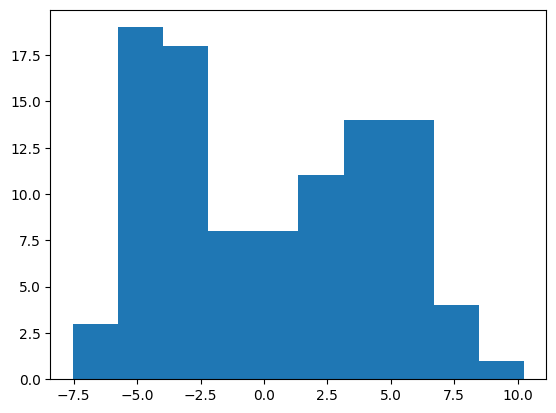

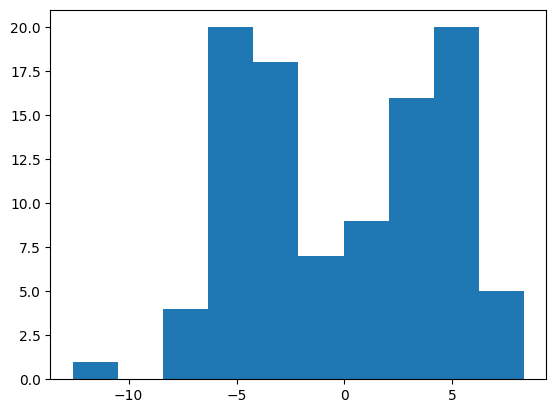

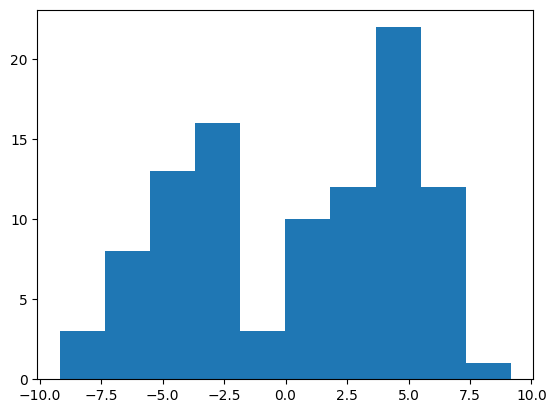

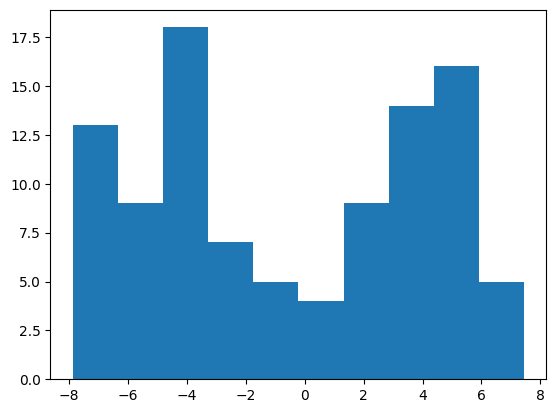

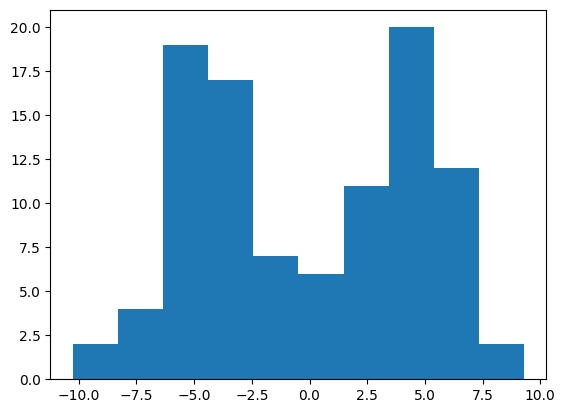

In [13]:
dg = DataGenerator(123)
for i in range(5):
    dg.generate_true_X([10000, 100], {'k': 2, 'diag': 1})
    dg.generate_coefs(4, 0.5)
    plt.hist(dg.coefs)
    plt.show()

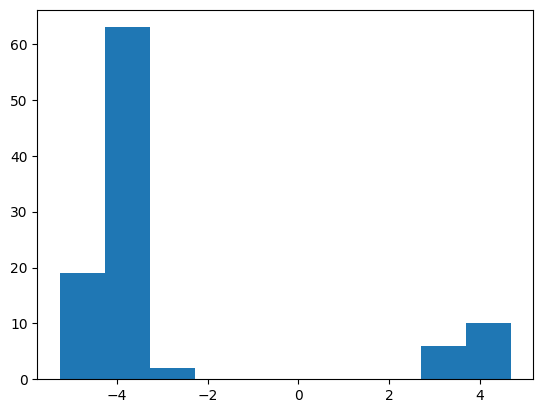

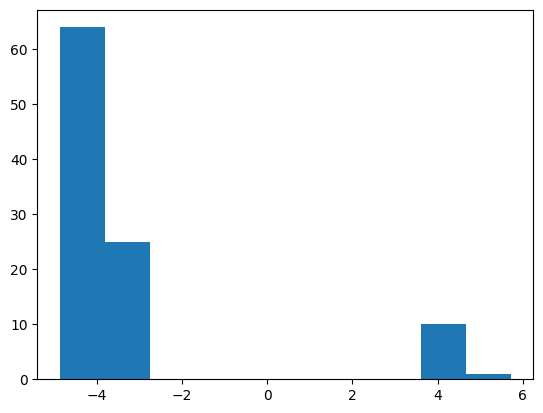

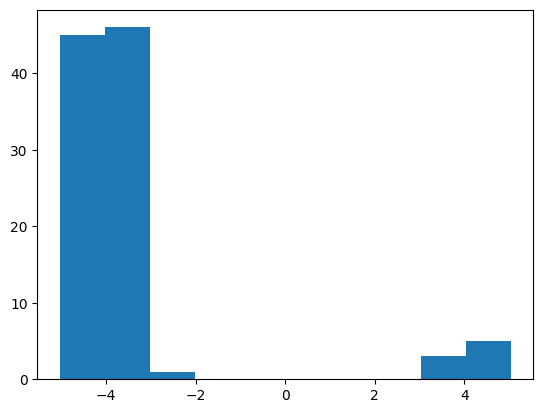

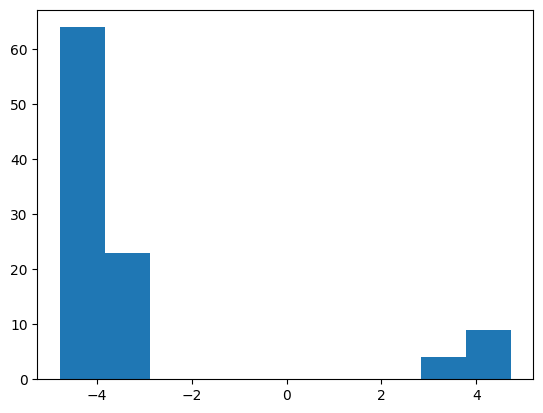

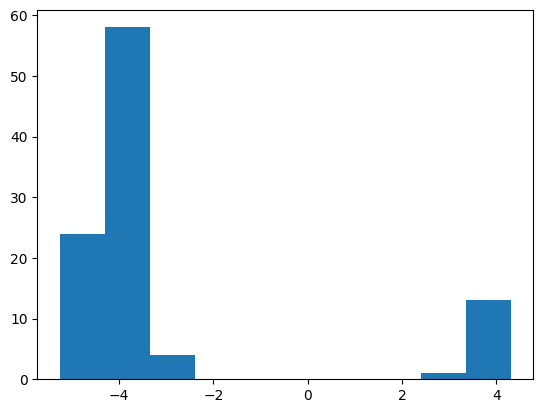

In [10]:
dg = DataGenerator(123)
for i in range(5):
    dg.generate_true_X([10000, 100], {'k': 2, 'diag': 1})
    dg.generate_coefs(4, 0.1, 0.9)
    plt.hist(dg.coefs)
    plt.show()

# Test generate Y

In [14]:
dg = DataGenerator(123)
for i in range(5):
    dg.generate_true_X([10000, 100], {'k': 2, 'diag': 1})
    dg.generate_coefs(4, 0.5)
    dg.generate_Y(1)
    err = dg.true_X.dot(dg.coefs) - dg.Y
    print(np.var(err))
    print(np.corrcoef(np.c_[err, np.roll(err, 1)], rowvar=False))

1.0150284812675852
[[ 1.         -0.00699322]
 [-0.00699322  1.        ]]
0.9926401847621562
[[ 1.         -0.00148826]
 [-0.00148826  1.        ]]
0.9971749827938271
[[ 1.         -0.00228794]
 [-0.00228794  1.        ]]
1.0007049242772574
[[1.         0.01423486]
 [0.01423486 1.        ]]
0.9957797837017064
[[1.         0.00731392]
 [0.00731392 1.        ]]


In [15]:
dg = DataGenerator(123)
for i in range(5):
    dg.generate_true_X([10000, 100], {'k': 2, 'diag': 1})
    dg.generate_coefs(4, 0.5)
    dg.generate_Y(1, 0.3)
    err = dg.true_X.dot(dg.coefs) - dg.Y
    print(np.var(err))
    print(np.corrcoef(np.c_[err, np.roll(err, 1)], rowvar=False))

1.0090429182791507
[[1.         0.29068575]
 [0.29068575 1.        ]]
0.9924044348143525
[[1.         0.29964194]
 [0.29964194 1.        ]]
0.9994049310239858
[[1.         0.30311957]
 [0.30311957 1.        ]]
1.0081747233950584
[[1.         0.31122242]
 [0.31122242 1.        ]]
1.002606510368123
[[1.         0.31035111]
 [0.31035111 1.        ]]


# Test generate_obs_X

In [16]:
dg.generate_observed_X()

In [17]:
np.corrcoef(np.c_[dg.Y, dg.obs_X], rowvar=False)[:, 0]/np.corrcoef(np.c_[dg.Y, dg.true_X], rowvar=False)[:, 0]

array([1.        , 0.5778427 , 0.60156816, 0.63701069, 0.5861605 ,
       0.53899527, 0.58952492, 0.57314707, 0.60433447, 0.63179133,
       0.61271206, 0.62527882, 0.63129239, 0.58223947, 0.50076623,
       0.65421888, 0.57810471, 0.60066778, 0.57092716, 0.47191645,
       0.64457821, 0.57436521, 0.56238547, 0.57264394, 0.6011484 ,
       0.59540595, 0.79260129, 0.7170862 , 0.58627798, 0.60257183,
       0.60032851, 0.35250844, 0.60969889, 0.58185614, 0.63332739,
       0.60874174, 0.58603857, 0.60146281, 0.5897903 , 0.71906651,
       0.553572  , 0.5988704 , 0.60271124, 0.61083775, 0.59014182,
       0.56419501, 0.65337583, 0.59735784, 0.46738107, 0.60930095,
       0.30023938, 0.58312977, 0.57989449, 0.33197415, 0.58947875,
       0.66514319, 0.63396742, 0.60909317, 0.53150094, 2.67388462,
       0.61278844, 0.61333952, 0.59703866, 0.5741351 , 0.53719448,
       1.31091318, 0.62876338, 5.85604586, 0.51926253, 0.61109945,
       0.50704471, 0.58059513, 0.63956971, 0.74337467, 0.53293

# Test generate_bad_features

In [18]:
dg.generate_bad_features(10)

In [19]:
dg.generate_bad_features(5, 0.95)

In [20]:
np.corrcoef(np.c_[dg.Y, dg.obs_X], rowvar=False)[101::, 0]

array([ 0.00327227,  0.00545045, -0.0046552 ,  0.00661591,  0.00367112,
       -0.01556787, -0.01566889, -0.00405398,  0.00667228, -0.00357091,
       -0.21663092, -0.13422484,  0.04502975, -0.21704981, -0.0630188 ])

In [21]:
np.abs(np.corrcoef(np.c_[dg.true_X, dg.obs_X[:, 110:]], rowvar=False)[100:, :-5]).max(axis=1)

array([0.99861777, 0.99862715, 0.99862443, 0.99862513, 0.99862393])

# Generate dataset with a dict

In [22]:
dataset_info = {
    'name': 'test_1',
    'shape': [1000, 50],
    'gen_true_X': {'variance': {'k': 1, 'diag': 1}},
    'gen_coefs': {'magnitude': 100, 'spread': 0.5, 'prop_neg': 0.6},
    'gen_Y': {'variance': 5, 'autocorr': 0.4},
    'gen_obs_X': {'coef': 0.7},
    'gen_bad_features': {'n': 5, 'prop': [0.05, 0.1, 0.95, 0.5, 0.0001]}
}

In [23]:
dg = DataGenerator(321)

In [24]:
dg.from_dict(dataset_info)

In [25]:
sma.OLS(dg.Y, dg.true_X).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   1.000
Model:                            OLS   Adj. R-squared (uncentered):              1.000
Method:                 Least Squares   F-statistic:                          3.903e+06
Date:                Thu, 19 Sep 2024   Prob (F-statistic):                        0.00
Time:                        01:16:15   Log-Likelihood:                         -2223.5
No. Observations:                1000   AIC:                                      4547.
Df Residuals:                     950   BIC:                                      4792.
Df Model:                          50                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            99.1333      0.077   1291.106      0.000      98.983      99.284
x2           -74.6671      0.074  -1007.698      0.000     -74.812     -74.522
x3            25.9822      0.076    344.008      0.000      25.834      26.130
x4           -93.0759      0.072  -1292.496      0.000     -93.217     -92.935
x5           -91.7501      0.076  -1207.573      0.000     -91.899     -91.601
x6            85.6430      0.071   1201.176      0.000      85.503      85.783
x7            43.0228      0.075    573.652      0.000      42.876      43.170
x8           128.3507      0.077   1670.891      0.000     128.200     128.501
x9            54.9396      0.075    728.197      0.000      54.792      55.088
x10          148.3320      0.076   1961.548      0.000     148.184     148.480
x11           -1.9380      0.075    -25.719      0.000      -2.086      -1.790
x12         -131.0019      0.074  -1760.327      0.000    -131.148    -130.856
x13           97.4096      0.073   1335.331      0.000      97.266      97.553
x14          -71.0417      0.076   -928.852      0.000     -71.192     -70.892
x15         -187.7806      0.073  -2572.591      0.000    -187.924    -187.637
x16          -91.2123      0.075  -1214.566      0.000     -91.360     -91.065
x17         -111.6601      0.075  -1492.629      0.000    -111.807    -111.513
x18          -48.2266      0.073   -656.215      0.000     -48.371     -48.082
x19          -70.8125      0.075   -946.985      0.000     -70.959     -70.666
x20            0.9590      0.076     12.680      0.000       0.811       1.107
x21          102.6505      0.074   1394.599      0.000     102.506     102.795
x22          -35.3093      0.071   -497.120      0.000     -35.449     -35.170
x23          -75.5360      0.074  -1015.546      0.000     -75.682     -75.390
x24          146.3647      0.072   2040.342      0.000     146.224     146.506
x25         -183.5647      0.077  -2378.718      0.000    -183.716    -183.413
x26          -55.1777      0.074   -749.979      0.000     -55.322     -55.033
x27           96.2994      0.074   1310.114      0.000      96.155      96.444
x28          163.0766      0.074   2198.815      0.000     162.931     163.222
x29          176.8955      0.072   2464.914      0.000     176.755     177.036
x30          103.7608      0.072   1437.074      0.000     103.619     103.903
x31          -91.0207      0.069  -1327.853      0.000     -91.155     -90.886
x32           50.8068      0.072    703.027      0.000      50.665      50.949
x33         -201.8610      0.074  -2740.386      0.000    -202.006    -201.716
x34           35.6872      0.072    493.899      0.000      35.545      35.829
x35          110.6008      0.077   1433.082      0.000     11

In [26]:
sma.OLS(dg.Y, dg.obs_X).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.647
Model:                            OLS   Adj. R-squared (uncentered):              0.627
Method:                 Least Squares   F-statistic:                              31.55
Date:                Thu, 19 Sep 2024   Prob (F-statistic):                   9.57e-176
Time:                        01:16:16   Log-Likelihood:                         -7818.7
No. Observations:                1000   AIC:                                  1.575e+04
Df Residuals:                     945   BIC:                                  1.602e+04
Df Model:                          55                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            57.3658     14.154      4.053      0.000      29.589      85.143
x2           -40.6803     13.641     -2.982      0.003     -67.450     -13.911
x3           -13.2657     14.287     -0.928      0.353     -41.304      14.773
x4           -49.5758     13.057     -3.797      0.000     -75.200     -23.951
x5           -36.3984     14.723     -2.472      0.014     -65.292      -7.504
x6             8.1824      8.344      0.981      0.327      -8.192      24.557
x7            43.0134     12.999      3.309      0.001      17.503      68.524
x8            49.9383     14.230      3.509      0.000      22.012      77.865
x9            53.3374     13.869      3.846      0.000      26.119      80.556
x10           60.7308     14.259      4.259      0.000      32.748      88.714
x11           11.5816     14.121      0.820      0.412     -16.131      39.295
x12          -72.2129     13.922     -5.187      0.000     -99.535     -44.891
x13            9.2275      9.431      0.978      0.328      -9.280      27.735
x14          -61.2858     13.951     -4.393      0.000     -88.664     -33.908
x15          -81.2832     13.622     -5.967      0.000    -108.015     -54.551
x16          -29.5028     12.774     -2.310      0.021     -54.571      -4.434
x17          -25.4860     11.380     -2.240      0.025     -47.818      -3.154
x18          -35.4951     13.934     -2.547      0.011     -62.841      -8.149
x19          -50.2376     13.457     -3.733      0.000     -76.646     -23.829
x20           36.3409     13.876      2.619      0.009       9.109      63.573
x21           66.8919     13.262      5.044      0.000      40.866      92.918
x22          -35.8992     13.355     -2.688      0.007     -62.109      -9.690
x23          -46.5315     14.693     -3.167      0.002     -75.365     -17.698
x24           55.0520     12.972      4.244      0.000      29.596      80.509
x25          -59.0304     12.973     -4.550      0.000     -84.490     -33.570
x26          -32.4626     13.478     -2.409      0.016     -58.913      -6.012
x27           44.5868     11.361      3.925      0.000      22.291      66.883
x28           28.7415     11.932      2.409      0.016       5.326      52.157
x29           65.3967      9.011      7.258      0.000      47.714      83.080
x30           49.8855     10.318      4.835      0.000      29.636      70.135
x31           12.7012      8.667      1.466      0.143      -4.307      29.709
x32           43.5694     13.586      3.207      0.001      16.907      70.232
x33          -98.3685     13.835     -7.110      0.000    -125.520     -71.217
x34           17.7366     12.047      1.472      0.141      -5.906      41.380
x35           67.6167     14.709      4.597      0.000      3

In [27]:
np.corrcoef(np.c_[dg.errors, np.roll(dg.errors, 1)], rowvar=False)

array([[1.        , 0.39111034],
       [0.39111034, 1.        ]])